In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import graphs_config
from utils.functions import fit_step_titanic, calc_accuracy_titanic, calc_loss_titanic, update_params_titanic
from networks.logreg_model_titanic import LogRegTitanic

from utils.consensus_node import ConsensusNode
from utils.master_node import MasterNode

Подготовка датасета Титаник

In [14]:
def prepare_dataset(df):
    df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
    df['Sex'] = (train_data['Sex'] == 'male').astype(np.int) * 2 - 1
    df = df.fillna({'Age': df['Age'].mean()})
    df['Age'] /= 100
    df['Fare'] /= 100
    df['_bias'] = 1
    if 'Survived' in df.columns:
        return df.drop(['Survived'], axis=1), (df['Survived'] * 2 - 1)
    else:
        return df

train_data = pd.read_csv('../data/titanic/train.csv')
train_features, train_answers = prepare_dataset(train_data)

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', '_bias']
X = train_features[features].to_numpy()
y = train_answers.to_numpy()

common_test_X, common_test_y = X[:X.shape[0] // 10], y[:X.shape[0] // 10]
X_train, y_train = X[X.shape[0] // 10:], y[X.shape[0] // 10:]

test_loader = (common_test_X, common_test_y)

def get_train_loaders(topology):
    n_agents = len(topology)

    X_train_parts = np.array_split(X_train, n_agents)
    y_train_parts = np.array_split(y_train, n_agents)

    return {node_name: [(x, y)] for node_name, x, y in zip(topology, X_train_parts, y_train_parts)}

Генерация моделей консенсуса

In [15]:
model = LogRegTitanic
model_args = [X.shape[1]]

def consensus_model(topology, iterations=30000, consensus=True):
    update_params_epoch_start = 1 if consensus else iterations + 1
    
    master = MasterNode(node_names=topology.keys(),
                    weights=topology, # param_a = a*param_a + b*param_b + c*param_c, where a + b + c = 1.0
                    train_loaders=get_train_loaders(topology), # dict of train loaders, train_loaders[node_name] = train loader for node_name
                    test_loader=test_loader, # general test loader
                    fit_step=fit_step_titanic,
                    update_params=update_params_titanic,
                    calc_accuracy=calc_loss_titanic,
                    stat_step=1, # save statistic each stat step 
                    epoch=iterations, # number of epochs
                    epoch_len=1, # length each epoch
                    update_params_epoch_start=update_params_epoch_start, # the first epoch from which consensus begins
                    update_params_period=1, # consensus iteration period
                    verbose=0 # verbose mode
                   )

    master.set_model(model, *model_args)
    master.initialize_nodes()
    master.start_consensus()
    return master

Консенсусные модели с различными толопогиями

In [19]:
top5 = consensus_model(graphs_config.TOP_5)

Master started

Master ended in 36.04 sec



In [16]:
abc3 = consensus_model(graphs_config.ABC_3)

Master started

Master ended in 23.59 sec



In [20]:
O_o_edges = [(1, 2), (2, 3), (3, 4), (4, 1), (4, 5), (5, 6), (6, 7), (7, 5)]
O_o_topology = graphs_config.edges2topology(O_o_edges)
O_o = consensus_model(O_o_topology)

Master started

Master ended in 45.68 sec



Одиночная модель без консенсуса

In [17]:
lonely = consensus_model(graphs_config.LONELY, consensus=False)

Master started

Master ended in 10.27 sec



### Сравнение сходимости консенсусной и одиночной модели

In [23]:
def show_graphs(consensus, lonely):
    fig, axs = plt.subplots(figsize=(20, 8), ncols=2)
    fig.suptitle('Consensus vs. lonely', fontsize=24)
    fig.tight_layout(pad=4.0)
    for node in consensus.network.values():
        axs[0].plot(node.accuracy_list[1], node.accuracy_list[0], linestyle='--', color='k')
        axs[1].plot(node.loss_list[1], node.loss_list[0], linestyle='--', color='k')
    for node in lonely.network.values():
        axs[0].plot(node.accuracy_list[1], node.accuracy_list[0], color='r')
        axs[1].plot(node.loss_list[1], node.loss_list[0], color='r')
    axs[0].set_title('Test loss')
    axs[0].set_xlabel('Iteration', fontsize=16)
    axs[0].set_ylabel('Accuracy', fontsize=16)
    axs[1].set_title('Train loss')
    axs[1].set_xlabel('Iteration', fontsize=16)
    axs[1].set_ylabel('Loss', fontsize=16)

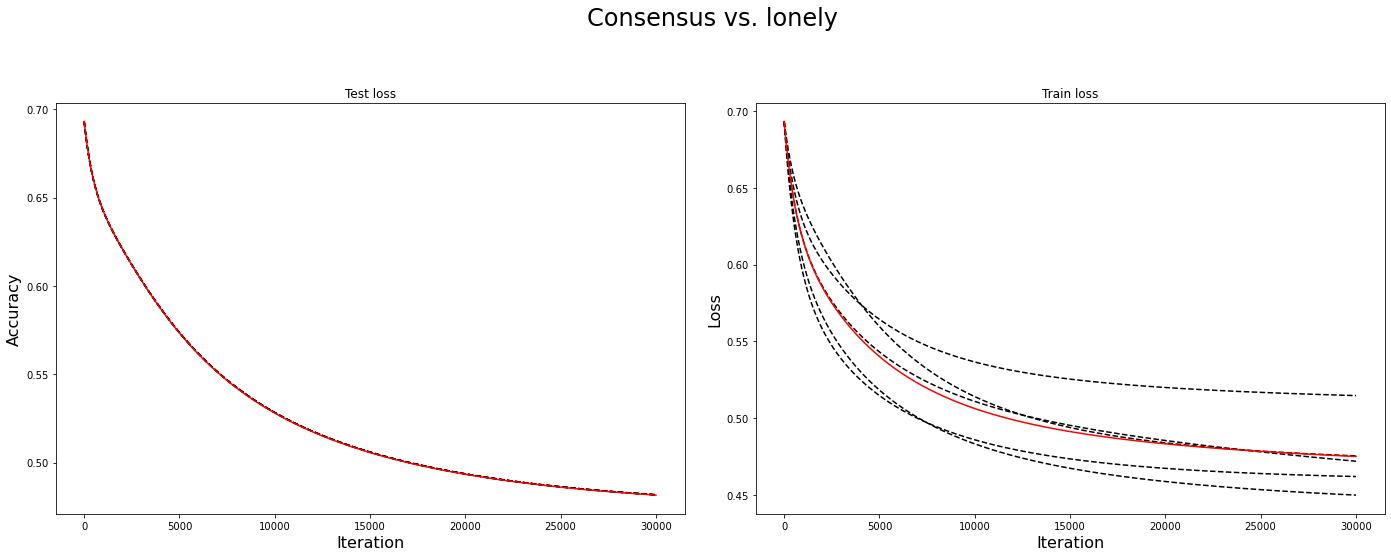

In [24]:
show_graphs(top5, lonely)

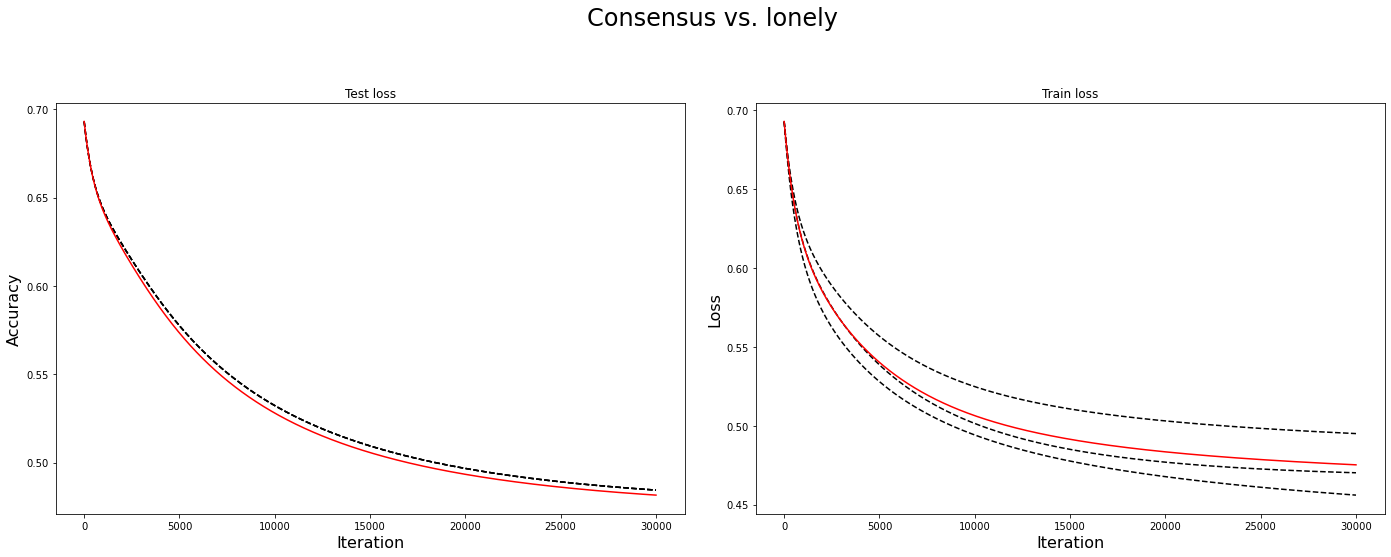

In [25]:
show_graphs(abc3, lonely)

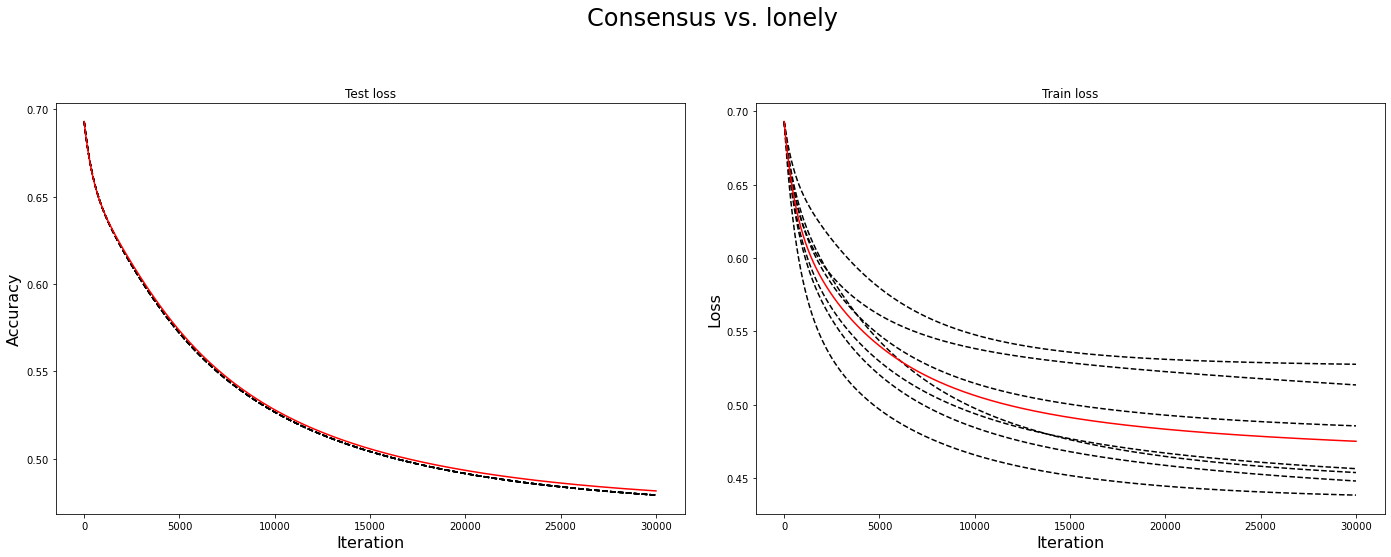

In [26]:
show_graphs(O_o, lonely)